In [1]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
ar = pd.read_csv('data/application_record.zip', compression='zip')
cr = pd.read_csv('data/credit_record.zip', compression='zip')

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['application_record.csv', 'credit_record.csv']

In [41]:
ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [42]:
ar['ID'].nunique()

438510

In [43]:
ar.drop_duplicates('ID', keep='last', inplace=True)
ar.shape

(438510, 18)

- **0:** 1-29 days past due 
- **1:** 30-59 days past due 
- **2:** 60-89 days overdue 
- **3:** 90-119 days overdue 
- **4:** 120-149 days overdue 
- **5:** Overdue or bad debts, write-offs for more than 150 days 
- **C:** paid off that month 
- **X:** No loan for the month

In [44]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [45]:
cr['ID'].unique().size

45985

In [46]:
pd.merge(ar, cr, on='ID', how='inner')['ID'].nunique()

36457

In [ ]:
# преобработка данных

# подставить актуальные даты вместо отрицательных чисел
# заменить Y N на true/false

In [47]:
ar.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134187
CNT_FAM_MEMBERS             0
dtype: int64

In [48]:
ar.drop('OCCUPATION_TYPE', axis=1, inplace=True)

<AxesSubplot:>

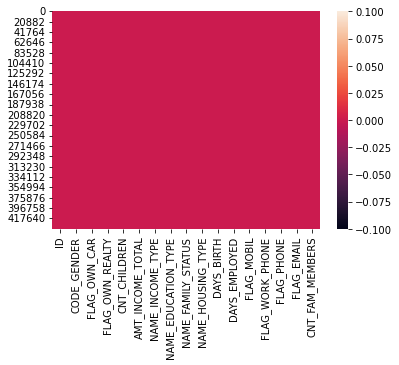

In [49]:
sns.heatmap(ar.isnull())

<AxesSubplot:>

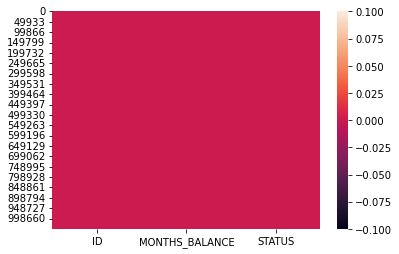

In [50]:
sns.heatmap(cr.isnull())

In [61]:
ar['ID'].dtype

dtype('int64')

In [62]:
ar.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
CNT_FAM_MEMBERS        float64
dtype: object

In [63]:
pd.DataFrame(ar.dtypes == 'object')

,0
ID,False
CODE_GENDER,True
FLAG_OWN_CAR,True
FLAG_OWN_REALTY,True
CNT_CHILDREN,False
AMT_INCOME_TOTAL,False
NAME_INCOME_TYPE,True
NAME_EDUCATION_TYPE,True
NAME_FAMILY_STATUS,True
NAME_HOUSING_TYPE,True


In [60]:
object_type = pd.DataFrame(ar.dtypes =='object').reset_index()
object_type

,index,0
0,ID,False
1,CODE_GENDER,True
2,FLAG_OWN_CAR,True
3,FLAG_OWN_REALTY,True
4,CNT_CHILDREN,False
5,AMT_INCOME_TOTAL,False
6,NAME_INCOME_TYPE,True
7,NAME_EDUCATION_TYPE,True
8,NAME_FAMILY_STATUS,True
9,NAME_HOUSING_TYPE,True


In [65]:
object_type = object_type[object_type[0] == True]['index']
object_type

1            CODE_GENDER
2           FLAG_OWN_CAR
3        FLAG_OWN_REALTY
6       NAME_INCOME_TYPE
7    NAME_EDUCATION_TYPE
8     NAME_FAMILY_STATUS
9      NAME_HOUSING_TYPE
Name: index, dtype: object

In [73]:
ar['CODE_GENDER'].value_counts()

F    294412
M    144098
Name: CODE_GENDER, dtype: int64

In [75]:
ar.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0


In [76]:
le = LabelEncoder()
for x in ar:
    if ar[x].dtypes == 'object':
        ar[x] = le.fit_transform(ar[x])

In [77]:
ar.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,2.0
1,5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,2.0
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,2.0
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,1.0
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,1.0


In [87]:
cr['STATUS'].value_counts() 

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [92]:
cr['STATUS'] = cr['STATUS'].replace({'C' : 0, 'X' : 0})
cr['STATUS'] = cr['STATUS'].astype(int)
cr['STATUS'].value_counts() 

0    1034381
1      11090
5       1693
2        868
3        320
4        223
Name: STATUS, dtype: int64

In [90]:
ar['OVERDUE'] = ar['ID'].apply(lambda x : 1 if x in overdue_id else 0)
ar.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,OVERDUE
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [104]:
# ar = ar.drop(columns=['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
#                     'NAME_HOUSING_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])

ar = ar.drop(columns=['AMT_INCOME_TOTAL'])

X = ar.drop(columns='OVERDUE')
y = ar['OVERDUE']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [107]:
y_predictions = logreg.predict(X_test)

In [108]:
print("Accuracy:", accuracy_score(y_test, y_predictions))

Accuracy: 0.9905030098504195


In [109]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predictions))

Confusion Matrix:
 [[86879     0]
 [  833     0]]


In [102]:
print("Classification Report:\n", classification_report(y_test, y_predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     86879
           1       0.00      0.00      0.00       833

    accuracy                           0.99     87712
   macro avg       0.50      0.50      0.50     87712
weighted avg       0.98      0.99      0.99     87712



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
